# Conical Flow Diagram

This notebook shows how to visualize the Taylor-Maccoll equation for conical flow.

Given the nondimensional velocity $V^{'}$:

$$
V^{'} = \frac{V}{V_{max}}
$$

the Taylor-Maccoll equation is:

$$
\begin{equation}
\begin{aligned}
\frac{\gamma - 1}{2} &\left[ 1 - V^{'2}_{r} - \left(\frac{d V^{'}_{r}}{d \theta}\right)^{2} \right] \left[ 2 V^{'}_{r} + \frac{d V^{'}_{r}}{d \theta} \cot{\theta} + \frac{d^{2} V^{'}_{r}}{d \theta^{2}} \right] \\
& - \frac{d V^{'}_{r}}{d \theta} \left[ V^{'}_{r} \frac{d V^{'}_{r}}{d \theta} + \frac{d V^{'}_{r}}{d \theta} \frac{d^{2} V^{'}_{r}}{d \theta^{2}} \right] = 0
\end{aligned}
\end{equation}
$$

where $V^{'}_{r}$ is the nondimensional velocity component along a ray starting at the tip of the cone.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from pygasflow.shockwave import (
    mach_cone_angle_from_shock_angle,
    max_theta_c_from_mach,
    beta_theta_c_for_unit_mach_downstream,
    load_data
)
import numpy as np

To generate the Mach curves we will use the `mach_cone_angle_from_shock_angle` function:

In [2]:
help(mach_cone_angle_from_shock_angle)

Help on function mach_cone_angle_from_shock_angle in module pygasflow.shockwave:

mach_cone_angle_from_shock_angle(M, beta, gamma=1.4)
    Compute the half-cone angle and the Mach number at the surface of the cone.
    NOTE: this function is undecorated, hence no check is performed to assure
    the validity of the input parameters. It's up to the user to assure that.
    
    Parameters
    ----------
    M : float
        Upstream Mach number. Must be > 1.
    beta : float
        Shock Angle in degrees. Must be mach_angle <= beta <= 90.
        NOTE: no check is done over beta. If an error is raised during the
        computation, make sure beta is at least ever so slightly bigger than
        the mach angle.
    gamma : float, optional
        Specific heats ratio. Default to 1.4. Must be > 1.
    
    Returns
    -------
    Mc : float
        Mach number at the surface of the cone
    theta_c : float
        Half-cone angle in degrees.



Essentialy, we create an array containing the interested Mach numbers and we will loop over it, integrating the Taylor-Maccoll equation for the specified parameters.

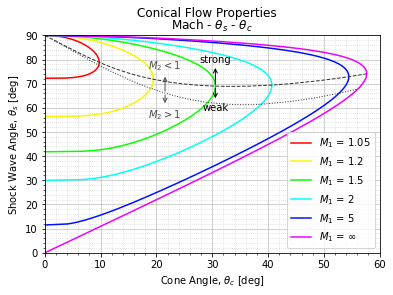

In [3]:
Minf = [1.05, 1.2, 1.5, 2, 5, 10000]
gamma = 1.4
N = 200

# colors
jet = plt.get_cmap('hsv')
cNorm  = colors.Normalize(vmin=0, vmax=len(Minf))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
c = [scalarMap.to_rgba(i) for i in range(len(Minf))]
# labels
lbls = [r"$M_{1}$ = " + str(Minf[i]) for  i in range(len(Minf))]
lbls[-1] = r"$M_1$ = $\infty$"

plt.figure()
for j, M in enumerate(Minf):
    theta_c = np.zeros(N)
    # NOTE: to avoid errors in the integration process of Taylor-Maccoll equation,
    # beta should be different than Mach angle and 90deg, hence an offset is applied.
    offset = 1e-08
    theta_s = np.linspace(np.rad2deg(np.arcsin(1 / M)) + offset, 90 - offset, N)
    for i, ts in enumerate(theta_s):
        Mc, tc = mach_cone_angle_from_shock_angle(M, ts, gamma)
        theta_c[i] = tc
    theta_c = np.insert(theta_c, 0, 0)
    theta_c = np.append(theta_c, 0)
    theta_s = np.insert(theta_s, 0, np.rad2deg(np.arcsin(1 / M)))
    theta_s = np.append(theta_s, 90)
    plt.plot(theta_c, theta_s, color=c[j], label=lbls[j])

# Compute the line passing through theta_c_max
M = np.asarray([1.0005, 1.0025, 1.005, 1.025, 1.05, 1.07, 1.09, 
                1.12, 1.15, 1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5, 
                1.6, 1.75, 2, 2.25, 3, 4, 5, 10, 100, 10000])
b = np.zeros_like(M)
tc = np.zeros_like(M)
for i, m in enumerate(M):
    _, tc[i], b[i] = max_theta_c_from_mach(m, gamma)
tc = np.insert(tc, 0, 0)
b = np.insert(b, 0, 90)
plt.plot(tc, b, '--', color="0.2", linewidth=1)

# select an index where to put the annotation (chosen by trial and error)
i = 16
plt.annotate("strong", 
    (tc[i], b[i]),
    (tc[i], b[i] + 10),
    horizontalalignment='center',
    arrowprops=dict(arrowstyle = "<-")
)
plt.annotate("weak", 
    (tc[i], b[i]),
    (tc[i], b[i] - 10),
    horizontalalignment='center',
    arrowprops=dict(arrowstyle = "<-"),
)

M, beta, theta_c = load_data(gamma)
plt.plot(np.asarray(theta_c), np.asarray(beta), ':', color="0.2", linewidth=1)

i = 54
plt.annotate("$M_{2} < 1$", 
    (theta_c[i], beta[i]),
    (theta_c[i], beta[i] + 10),
    horizontalalignment='center',
    arrowprops=dict(arrowstyle = "<-", color="0.3"),
    color="0.3",
)
plt.annotate("$M_{2} > 1$", 
    (theta_c[i], beta[i]),
    (theta_c[i], beta[i] - 10),
    horizontalalignment='center',
    arrowprops=dict(arrowstyle = "<-", color="0.3"),
    color="0.3",
)

# If there is no data for M2=1, we just need to generate it. IT IS SLOW!!!
# M = np.asarray([1.05, 1.2, 1.35, 1.5, 2, 3, 5, 10000])
# beta = np.zeros_like(M)
# theta_c = np.zeros_like(M)
# for i, m in enumerate(M):
#     beta[i], theta_c[i] = beta_theta_c_for_unit_mach_downstream(m, gamma)
# theta_c = np.insert(theta_c, 0, 0)
# beta = np.insert(beta, 0, 90)
# plt.plot(theta_c, beta, ':', color="0.2", linewidth=1)

plt.suptitle("Conical Flow Properties")
plt.title(r"Mach - $\theta_{s}$ - $\theta_{c}$")
plt.xlabel(r"Cone Angle, $\theta_{c}$ [deg]")
plt.ylabel(r"Shock Wave Angle, $\theta_{s}$ [deg]")
plt.xlim((0, 60))
plt.ylim((0, 90))
plt.minorticks_on()
plt.grid(which='major', linestyle='-', alpha=0.7)
plt.grid(which='minor', linestyle=':', alpha=0.5)
plt.legend(loc="lower right")
plt.show()